In [620]:
###Packages & Setup###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Point
from matplotlib.collections import PatchCollection

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import graphviz 
from sklearn.tree import export_graphviz

%matplotlib inline

In [699]:
###Load in data###

avocado = pd.read_csv('avocado.csv')
cities = pd.read_csv('uscities.csv')

In [723]:
###Standardizing city names so we get all of the cities we want when we merge###

cities.city = cities.city.str.replace(' ', '').str.lower()
avocado.region = avocado.region.str.lower()

###Merge and turn into time series###

data = avocado.merge(cities, left_on='region', right_on='city', how='left')
data.index = pd.to_datetime(data['Date'])

In [4]:
###Cleaning up data###

country = country[(country['NAME'] != 'Alaska') & (country['NAME'] != 'Puerto Rico') & (country['NAME'] != 'Hawaii')]

data = data[(data['city'] != 'west') & (data['city'] != 'california') & (data['city'] != 'plains')
            & (data['city'] != 'northeast') & (data['population'] > 100000) & (data['state_name'] != 'Maine')]
data = data.loc[~((data['state_name'] == 'North Carolina') & (data['city'] == 'jacksonville')),:]
data = data.loc[~((data['state_name'] == 'Georgia') & (data['city'] == 'columbus')),:]

In [623]:
###Zipping Latitude and Longitude###

data = data[(data['lng'] < 0) & (data['lng'] > -140)]
data['coordinates'] = [
    Point(long, lat) 
    for long, lat 
    in zip(data['lng'], data['lat'])
]
data = gpd.GeoDataFrame(data, geometry='coordinates')

In [752]:
###Machine Learning###

City = 'newyork'

data1 = data[['AveragePrice', 'Total Volume', 'city', 'Total Bags', 'Small Bags', 'population', 'density']]
data1 = data1[data1['city'] == City][0:169]
data1 = data1.drop(columns=['city'])

In [753]:
avg_features = data1.loc[:, data1.columns != 'AveragePrice']
avg_labels = data1['AveragePrice']

avg_features_train, avg_features_test, avg_labels_train, avg_labels_test = \
    train_test_split(avg_features, avg_labels, train_size=.30788, shuffle=False)

lst = []
for max_depth in range(1, 200):
    avg_model = DecisionTreeRegressor(max_depth=max_depth)
    avg_model.fit(avg_features_train, avg_labels_train)

    avg_train_predictions = avg_model.predict(avg_features_train)
    avg_test_predictions = avg_model.predict(avg_features_test)

    lst.append(mean_squared_error(avg_labels_test, avg_test_predictions))
max_depth = lst.index(min(lst)) + 1

In [765]:
avg_model = DecisionTreeRegressor(max_depth=max_depth)
avg_model.fit(avg_features_train, avg_labels_train)

avg_train_predictions = avg_model.predict(avg_features_train)
avg_test_predictions = avg_model.predict(avg_features_test)

avg_train_err = mean_squared_error(avg_labels_train, avg_train_predictions)
avg_test_err = mean_squared_error(avg_labels_test, avg_test_predictions)

In [755]:
data1['Avg Price Prediction'] = np.append(avg_train_predictions, avg_test_predictions)
avg_predict = data1['Avg Price Prediction']
avg_total = data1['AveragePrice']

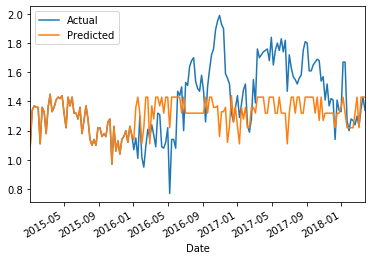

In [756]:
fig, ax = plt.subplots()
avg_total.resample('W').mean().plot(ax=ax, label='Actual')
avg_predict.resample('W').mean().plot(ax=ax, label='Predicted')
ax.legend()

In [661]:
def plot_tree(model, features, labels):
    dot_data = export_graphviz(model, out_file=None, 
            feature_names=features.columns,  
            class_names=labels.unique(),
            impurity=False,
            filled=True, rounded=True,  
            special_characters=True) 
    return graphviz.Source(dot_data)

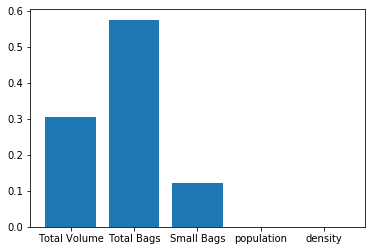

In [735]:
a = avg_model.feature_importances_
x = np.arange(5)
plt.bar(x, a)
plt.xticks(x, ('Total Volume', 'Total Bags', 'Small Bags', 'population', 'density'))
plt.show()

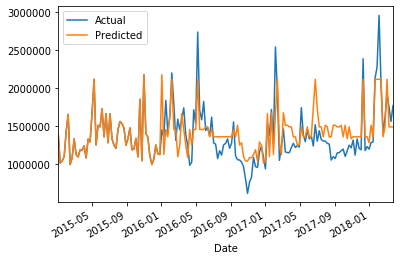

In [764]:
vol_features = data1.loc[:, data1.columns != 'Total Volume']
vol_labels = data1['Total Volume']

vol_features_train, vol_features_test, vol_labels_train, vol_labels_test = \
    train_test_split(vol_features, vol_labels, train_size=.30788, shuffle=False)

lst = []
for max_depth in range(1, 200):
    vol_model = DecisionTreeRegressor(max_depth=max_depth)
    vol_model.fit(vol_features_train, vol_labels_train)

    vol_train_predictions = vol_model.predict(vol_features_train)
    vol_test_predictions = vol_model.predict(vol_features_test)

    lst.append(mean_squared_error(vol_labels_test, vol_test_predictions))
max_depth = lst.index(min(lst)) + 1

vol_model = DecisionTreeRegressor(max_depth=max_depth)
vol_model.fit(vol_features_train, vol_labels_train)

vol_train_predictions = vol_model.predict(vol_features_train)
vol_test_predictions = vol_model.predict(vol_features_test)

vol_train_err = mean_squared_error(vol_labels_train, vol_train_predictions)
vol_test_err = mean_squared_error(vol_labels_test, vol_test_predictions)

data1['Total Volume Prediction'] = np.append(vol_train_predictions, vol_test_predictions)
vol_predict = data1['Total Volume Prediction']
vol_total = data1['Total Volume']

fig, ax = plt.subplots()
vol_total.plot(ax=ax, label='Actual')
vol_predict.plot(ax=ax, label='Predicted')
ax.legend()